# Lecture 22 - Markov Chain Monte Carlo II

## Objectives

+ Use the Metropolis-Hastings algorithm (the most general Markov Chain Monte Carlo (MCMC) algorithm) to sample from an arbitrary probability density known up to a normalization constant.
+ Build new algorithms with Metropolis-Hastings. Example: Metrpolis Adjusted Langevin Dynamics.
+ Combining transition kernels using (approximate) Gibbs sampling to sample from complicated joint distributions.
+ Use MCMC to calibrate the reaction kinetics problem using the Bayesian formulation.

## Readings

+ Chapter 11 of Bishop.
+ These notes.

In [1]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm # pip install tqdm or conda install tqdm - this is needed for plotting
                      # a progress bar
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')

def rwmetropolis(x0, log_h, n, sigma, args=()):
    """
    Random walk metropolis.
    
    :param x0:     The initial point (numpy array).
    :param log_h:  The logartihm of the function that is proportional to the density you want to sample from (function).
    :param n:      The maximum number of steps you want to take.
    :param sigma:  The standard deviation of the random walk proposal.
    :param args:   Any parameters to log_h.
    
    :returns:  X, acceptance_rate
    """
    x0 = np.array(x0)
    assert x0.ndim == 1
    # Dimensionality of space
    d = x0.shape[0]
    # A place to store the samples
    X = np.ndarray((n + 1, d))
    X[0, :] = x0
    # Previous value of log(h(x))
    log_h_p, other_p = log_h(x0, *args)
    # Storing other details per step
    other = [other_p]
    # Keep track of how many samples are accepted
    count_accepted = 0
    # Start the simulation
    for t in tqdm(range(1, n + 1), leave = False, position=0):
        # Generation
        x = X[t - 1, :] + sigma * np.random.randn(d)
        # Calculation
        log_h_c, other_c = log_h(x, *args) # Current value of log(h(x))
        alpha = min(1, np.exp(log_h_c - log_h_p))
        # Accept/Reject
        u = np.random.rand()
        if u <= alpha: # Accept
            X[t, :] = x
            other.append(other_c)
            log_h_p = log_h_c
            other_p = other_c
            count_accepted += 1
        else:          # Reject
            X[t, :] = X[t - 1, :]
            other.append(other_p)
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate, other

## Problem Definition

Without loss of generality, let $X\in\mathcal{X}\subset\mathbb{R}^d$ be random variable with an arbitrary probability density, say $\pi(x)$ known up to a normalization constant.
That is, we have that:
$$
\pi(x) = \frac{h(x)}{Z},
$$
where $h(x)$ is a known function that we can evaluate at will, but $Z$ is not known.
Our goal is to generate samples from $\pi(x)$, by only evaluating $h(x)$.
If you haven't done so, please go over [Lecture 21](handout_21.ipynb) before moving forward.

## The Metropolis-Hastings Algorithm

The Metroplis algorithm requires that the proposal kernel $T(x,x')$ is symmetric.
Hastings (1970) created an algorithm that does not require symmetric proposal kernels.
The only thing that changes is the acceptance ratio.
In every other regard, the algorithm is exactly the same:

+ **Initialization:** Pick an arbitrary starting point $x_0$.
+ For each time step $n$:
    - **Generation:** Sample a candidate $x$ from $T(x_n, x)$.
    - **Calculation:** Calculate the *acceptance ratio*:
    $$
    \alpha(x_n, x) = \min\left\{1, \frac{h(x)}{h(x_n)}\frac{T(x,x_n)}{T(x_n,x)}\right\}.
    $$
    This is the only place where you may need to evaluate the underlying model.
    - **Accept/Reject:**
        - Generate a uniform number $u\sim \mathcal{U}([0,1])$.
        - If $u\le \alpha$, *accept* and set $x_{n+1}=x$.
        - If $u > \alpha$, *reject* ad set $x_{n+1} = x_n$.
        
## Why Does Metropolis-Hastings Work?

Well, it works because it gives us a Markov chain with the desired equilibrium distribution.
That is, a chain that has an invariant distribution of our choice that it is also ergodic.

To show that $\pi(x)$ is the invariant distribution of the Metropolis-Hastings Markov chain, we will show that the latter **satisfies the detailed balance condition**.
To this end, we need the transition kernel of the chain.
The transition kernel $K(x,x')$ gives the probability that the Metropolis chain moves from $x$ to $x'$.
It is:
$$
K(x,x') = T(x,x')\alpha(x,x') + (1 - r(x))\delta(x' - x),
$$
where $T(x,x')$ is the transition kernel of the proposal distribution,
$$
\alpha(x,x') = \min\left\{1, \frac{h(x')}{h(x)}\frac{T(x',x)}{T(x,x')}\right\}
$$
is the acceptance ratio,
$$
r(x) = \int T(x, y)\alpha(x, y)dy,
$$
is the probability of accepting any move, i.e., $1 - r(x)$ is the probability of not accepting the move, and $\delta(x-x')$ is the Dirac delta centered at $x'$.

Let's prove that the detailed balance holds for this transition kernel.
For $x = x'$ the equation holds trivially (even though we would have to interpret it slightly differntly to be 100% rigorous).
For $x\not= x'$, we have:
$$
\begin{align*}
\pi(x) K(x, x') &= \frac{h(x)}{Z} T(x,x')\alpha(x,x') \\
&= \frac{h(x)}{Z}T(x,x')\min\left\{1, \frac{h(x')}{h(x)}\frac{T(x',x)}{T(x,x')}\right\}\\
&= \frac{h(x')}{h(x')}\frac{T(x',x)}{T(x',x)}\frac{h(x)}{Z}T(x,x')\min\left\{1, \frac{h(x')}{h(x)}\frac{T(x',x)}{T(x,x')}\right\}\\
&= \frac{h(x')}{Z}T(x',x)\min\left\{\frac{h(x)}{h(x')}\frac{T(x,x')}{T(x',x)},\frac{h(x)}{h(x')}\frac{T(x,x')}{T(x',x)}\cdot\frac{h(x')}{h(x)}\frac{T(x',x)}{T(x,x')}\right\}\\
&= \pi(x')T(x',x)\min\left\{\frac{h(x)}{h(x')\frac{T(x,x')}{T(x',x)}},1\right\}\\
&= \pi(x')T(x',x)\alpha(x',x)\\
&= \pi(x')K(x',x).
\end{align*}
$$

## The Metropolis-Hastings Algorithm is Not One Algorithm!

For every choice of proposal $T(x',x)$, you get a different MH algorithm.
This is extremely empowering, since you can construct an MH that best exploits your problem.
Over the years, several cases have been proposed that are extremely useful.
We enumerate a few:

+ [Metrpolis Adjusted Langevin Dynamics](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm): This algorithm uses gradient information to push your chain towards highly probable states.

+ [Hybrid Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo): This method associates the random variables you have with the generalized coordinates of a hypothetical physical system, and the negative log of the probability density you want to sample from with a fictitious energy. The proposal follows the hypothetical Hamiltonian dynamics with randomly sampled (fake) velocities. This moves you to low energy states which are associated with high probabilities.

+ [Riemannian Manifold Hamiltonian Monte Carlo](https://arxiv.org/abs/0907.1100): One of the most advanced algorithms. Like HMC, but it exploits the Riemannian structure of the parameter space to automatically adapts to local features.

## Metropolis Adjusted Langevin Dynamics (MALA)

Understanding Langevin dynamics fully requires familiarity with [Itô calculus](https://en.wikipedia.org/wiki/Itô_calculus).
The math is very advanced, but we will do our best to explain what is going on intuitively.
Remember that we want to sample from:
$$
\pi(x) = \frac{h(x)}{Z},
$$
where $Z$ is unknown.

Consider the stochastic differential equation (Itô diffusion):
$$
\dot{X}_t = -\nabla V(X_t) + \sqrt{2}\dot{W}_t,
$$
where the time is continuous, and $W_t$ is a Brownian motion.
This is called the Langevin equation.
Intuitively, think of $X_t$ as the position of a particle that wants to move towards regions of low potential energy $V(x)$ but it is bombarded continuously by random forces.
What we want to do, is pick a $V(x)$ that will force this fictitious particle to move towards regions of high $h(x)$.
This can be done in many ways, but let us take:
$$
V(x) = -\log h(x),
$$
because we already know the answer!
Using the theory of stochastic differential equations one can show that the distribution of $X_t$, say $\rho_t$, converges to a stationary distribution $\rho_\infty$.
Well, it turns out that:
$$
\rho_\infty(x) \propto h(x),
$$
i.e.,
$$
\rho_\infty = \pi.
$$

So, here is the idea:
+ simulate the Langevin equation for a large enough time
+ and you should get a sample from $\pi$.

The only issue is that you cannot get exact sample paths from the Langevin equation.
You have to use a time discretization scheme.
The simplest such scheme is the Euler-Maruyama method (generalization of the Euler method for ODEs to SODEs).
You fix a time step $\Delta t > 0$ and you take:
$$
X_{n+1} = X_n + \Delta t \nabla \log h(X_n) + \sqrt{2\Delta t}Z_n,
$$
where $Z_n\sim \mathcal{N}(0,I_d)$ independent.
This is basically a discrete time Markov chain with a non-symmetric transition kernel:
$$
T(x,x') = \mathcal{N}\left(x'|x + \Delta t\nabla \log h(x), 2\Delta t\right) \propto \exp\left\{-\frac{\parallel x+\Delta t \nabla \log h(x)-x'\parallel_2^2}{4\Delta t}\right\}.
$$
In the limit of $\Delta t\rightarrow 0$, you will get exact sample paths and, hence, samples from $\pi(x)$.
Unfortunately, for finite $\Delta t$, you will converge to a perturbed version of $\pi(x)$.
Fortunately, you can use $T(x,x')$ as the proposal kernel of a Metropolis-Hastings algorithm.
In other words, you can Metropolize the discretized version of the Langevin equation.
Then, your resulting Markov chain will satisfy the detailed balance for the right probability density and you are all set.
Let's try it.

In [2]:
def mala(x0, log_h, n, dt, args=()):
    """
    Metropolis Hastings Algorithm with Metropolis Adjusted Langevin Dynamics.
    
    :param x0:     The initial point (numpy array).
    :param log_h:  The logartihm of the function that is proportional to the density you want to sample from (function).
                   Returns also the gradient.
    :param n:      The maximum number of steps you want to take.
    :param dt:     The time step you want to use.
    :param args:   Any parameters to log_h
    
    :returns:  X, acceptance_rate
    """
    x0 = np.array(x0)
    assert x0.ndim == 1
    # Dimensionality of space
    d = x0.shape[0]
    # A place to store the samples
    X = np.ndarray((n + 1, d))
    X[0, :] = x0
    # Previous value of log(h(x))
    log_h_p, grad_log_h_p = log_h(x0, *args)

    # Keep track of how many samples are accepted
    count_accepted = 0
    # Start the simulation
    for t in tqdm(range(1, n + 1), leave = False, position=0):
        # Generation
        x = X[t - 1, :] + dt * grad_log_h_p + np.sqrt(2. * dt) * np.random.randn(d)
        # Calculation
        log_h_c, grad_log_h_c = log_h(x, *args) # Current value of log(h(x))
        log_alpha_1 = log_h_c - log_h_p
        log_T_p_to_c = -np.sum((x - X[t - 1, :] - dt * grad_log_h_p) ** 2 / (4. * dt))
        log_T_c_to_p = -np.sum((x + dt * grad_log_h_c - X[t - 1, :]) ** 2 / (4. * dt))
        log_alpha_2 = log_T_c_to_p - log_T_p_to_c
        log_alpha = log_alpha_1 + log_alpha_2
        alpha = min(1, np.exp(log_alpha))
        # Accept/Reject
        u = np.random.rand()
        if u <= alpha: # Accept
            X[t, :] = x
            log_h_p = log_h_c
            grad_log_h_p = grad_log_h_c
            count_accepted += 1
        else:          # Reject
            X[t, :] = X[t - 1, :]
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate

## Example 1: Sampling from a Gaussian with MALA

Let's take $\mathcal{X}=\mathbb{R}^2$ and:
$$
\pi(x) \propto h(x) = \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$
where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
We need:
$$
\log h(x) = -\frac{1}{2}(x-\mu)^T\Lambda (x-\mu),
$$
and
$$
\nabla \log h(x) = -\Lambda (x-\mu).
$$

In [3]:
def log_h_mvn(x, mu, Lambda):
    tmp = x - mu
    return -0.5 * np.dot(tmp, np.dot(Lambda, tmp)), -np.dot(Lambda, x - mu)

# The parameters of the disribution from which we wish to sample
mu = np.array([5., 2.])
Sigma = np.array([[1., .4],
                  [.3, 0.2]]) # This has to be positive definite - otherwise you will get garbage!
Lambda = np.linalg.inv(Sigma)

# Initialiazation:
x0 = np.random.randn(2)
# Parameters of the proposal:
dt = 0.25
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = mala(x0, log_h_mvn, n, dt, args=(mu, Lambda))

print('Acceptance rate: %1.2f' % acceptance_rate)

Acceptance rate: 0.00


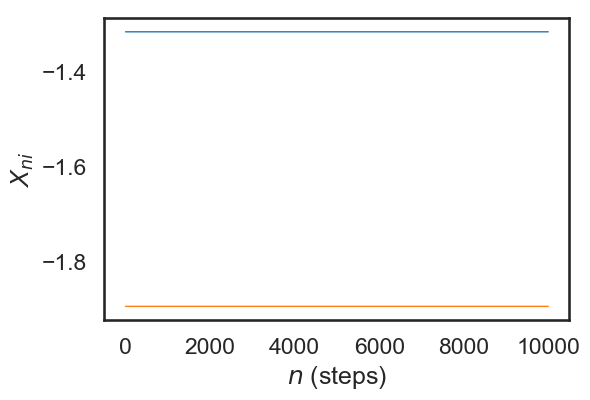

In [4]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

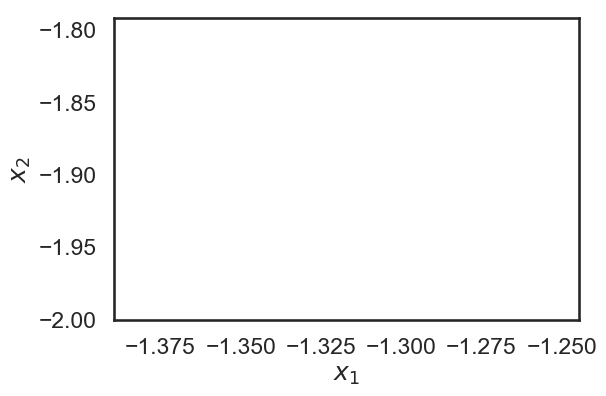

In [5]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

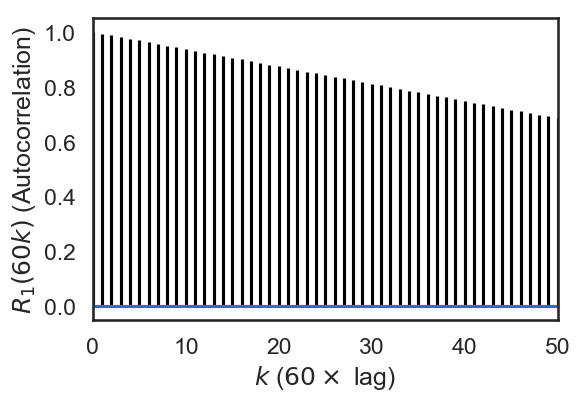

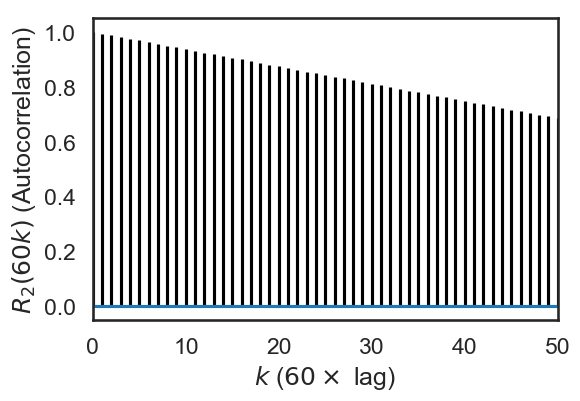

In [6]:
# How many samples do you want to burn?
burn = 500
# How many samples do you want to throw in between?
thin = 60 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(%d k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

## Example 2: The Catalysis Problem Revisited
For the full details of this problem, please see Lectures 19-20.
We will use the following prior:
$$
p(x) = \mathcal{N}(0,\gamma^2I).
$$
We need a prior on $\sigma$.
Let's pick:
$$
p(\sigma) \propto \frac{1}{\sigma}.
$$
We want to treat $\sigma$ and $x$ in the same way (one sampler), so let's introduce the following unknown vector to be inferred from the data:
$$
z = (x, \theta),
$$
where
$$
\theta = \log\sigma.
$$
On [Lecture 20](handout_20.ipynb) we saw that:
$$
p(\theta) \propto 1.
$$
Our posterior is for $z$ is:
$$
\pi(z) = p(z|y) \propto p(y|z)p(z) \propto h(z) = e^{-m\theta}\exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2e^{2\theta}}-\frac{1}{2\gamma^2}\parallel x\parallel_2^2\right\}.
$$

For MALA, we need:
$$
\log h(z) = -m\theta -\frac{1}{2}e^{-2\theta}\parallel y - f(x) \parallel_2^2 -\frac{1}{2\gamma^2}\parallel x\parallel_2^2,
$$
$$
\nabla_x \log h(z) = e^{-2\theta}(y-f(x))^T\nabla_x f(x) - \gamma^{-2}x,
$$
and
$$
\frac{\partial h(z)}{\partial \theta} = -m + e^{-2\theta}\parallel y - f(x) \parallel_2^2.
$$

**WARNING:** The code below will take at least 30 minutes.

In [7]:
# The data
import pandas as pd
import io
import requests
url="https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/lectures/catalysis.csv"
s=requests.get(url).content
catalysis_data = pd.read_csv(io.StringIO(s.decode('utf-8')))
catalysis_data
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)

# The experimental data as a matrix
Y = catalysis_data[1:].values

# The experimental as a vector
y = Y.flatten()

# The model
from demos.catalysis import CatalysisModel
solver = CatalysisModel()  

# The loss function
def L_with_jac(x, y):
    k = np.exp(x) / 180.
    sol = solver(k)
    y = y / 500.
    f = sol['f'][0][5:] / 500
    dfdk = sol['f_grad'][0][5:, :] / 500.
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (f - y)
    dLdx = np.einsum('ij,i->j', dfdx, tmp)
    L = 0.5 * np.sum(tmp ** 2)
    return L, dLdx

# For making predictions
import scipy.integrate

def A(x):
    """
    Return the matrix of the dynamical system.
    """
    # Scale back to the k's
    k = np.exp(x) / 180.
    res = np.zeros((6,6))
    res[0, 0] = -k[0]
    res[1, 0] = k[0]
    res[1, 1] = -(k[1] + k[3] + k[4])
    res[2, 1] = k[1]
    res[2, 2] = -k[2]
    res[3, 2] = k[2]
    res[4, 1] = k[4]
    res[5, 1] = k[3]
    return res
    

def g(z, t, x):
    """
    The right hand side of the dynamical system.
    """
    return np.dot(A(x), z)


# The full solution of the dynamical system
def cat_solver(x, t):
    """
    Returns the solution for parameters x at times t.
    """
    # The initial conditions
    z0 = np.array([500., 0., 0., 0., 0., 0.])
    return scipy.integrate.odeint(g, z0, t, args=(x,))


# This is what we need for MALA
def log_h_cat(z, y, gamma):
    m = y.shape[0]
    x = z[:5]
    theta = z[5]
    sigma = np.exp(theta)
    k = np.exp(x) / 180.
    sol = solver(k)
    f = sol['f'][0][5:]
    dfdk = sol['f_grad'][0][5:, :]
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (y - f)
    log_h = -m * theta - 0.5 * np.sum(tmp ** 2) / sigma ** 2 - 0.5 * np.sum(x ** 2) / gamma ** 2
    grad_x_log_h = np.einsum('ij,i->j', dfdx, tmp) / sigma ** 2 - x / gamma ** 2
    grad_theta_log_h = - m + np.sum(tmp ** 2) / sigma ** 2
    grad_log_h = np.hstack([grad_x_log_h, [grad_theta_log_h]])
    return log_h, grad_log_h


def m_log_h_cat(z, y, gamma):
    tmp1, tmp2 = log_h_cat(z, y, gamma)
    return -tmp1, -tmp2

In [8]:
# Any parameters we fix - RUNNING THIS WILL TAKE QUITE A BIT OF TIME
gamma = 10.

# Initialiazation:
x0 = np.random.randn(5)
sigma = 10.
theta = np.log(sigma)
z0 = np.hstack([x0, [theta]])

# Maximize posterior to select initial point
res = scipy.optimize.minimize(m_log_h_cat, z0, jac=True, args=(y, gamma))

# Parameters of the proposal:
dt = 1e-3

# Number of steps:
n = 10000

# Start sampling
Z, acceptance_rate = mala(res.x, log_h_cat, n, dt, args=(y, gamma))

print('Acceptance rate: %1.2f' % acceptance_rate)

Acceptance rate: 0.73


<font color='red'> 

1. Should we change $dt$ in above code to get the acceptance rate $\approx 0.25$? <br>
2. How would you know that the steps $n$ are suffiecient?
</font>

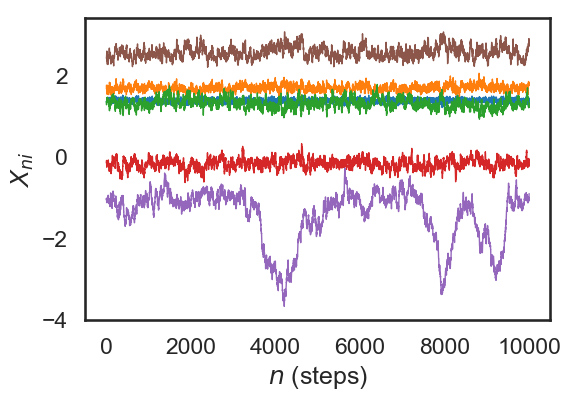

In [9]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), Z, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

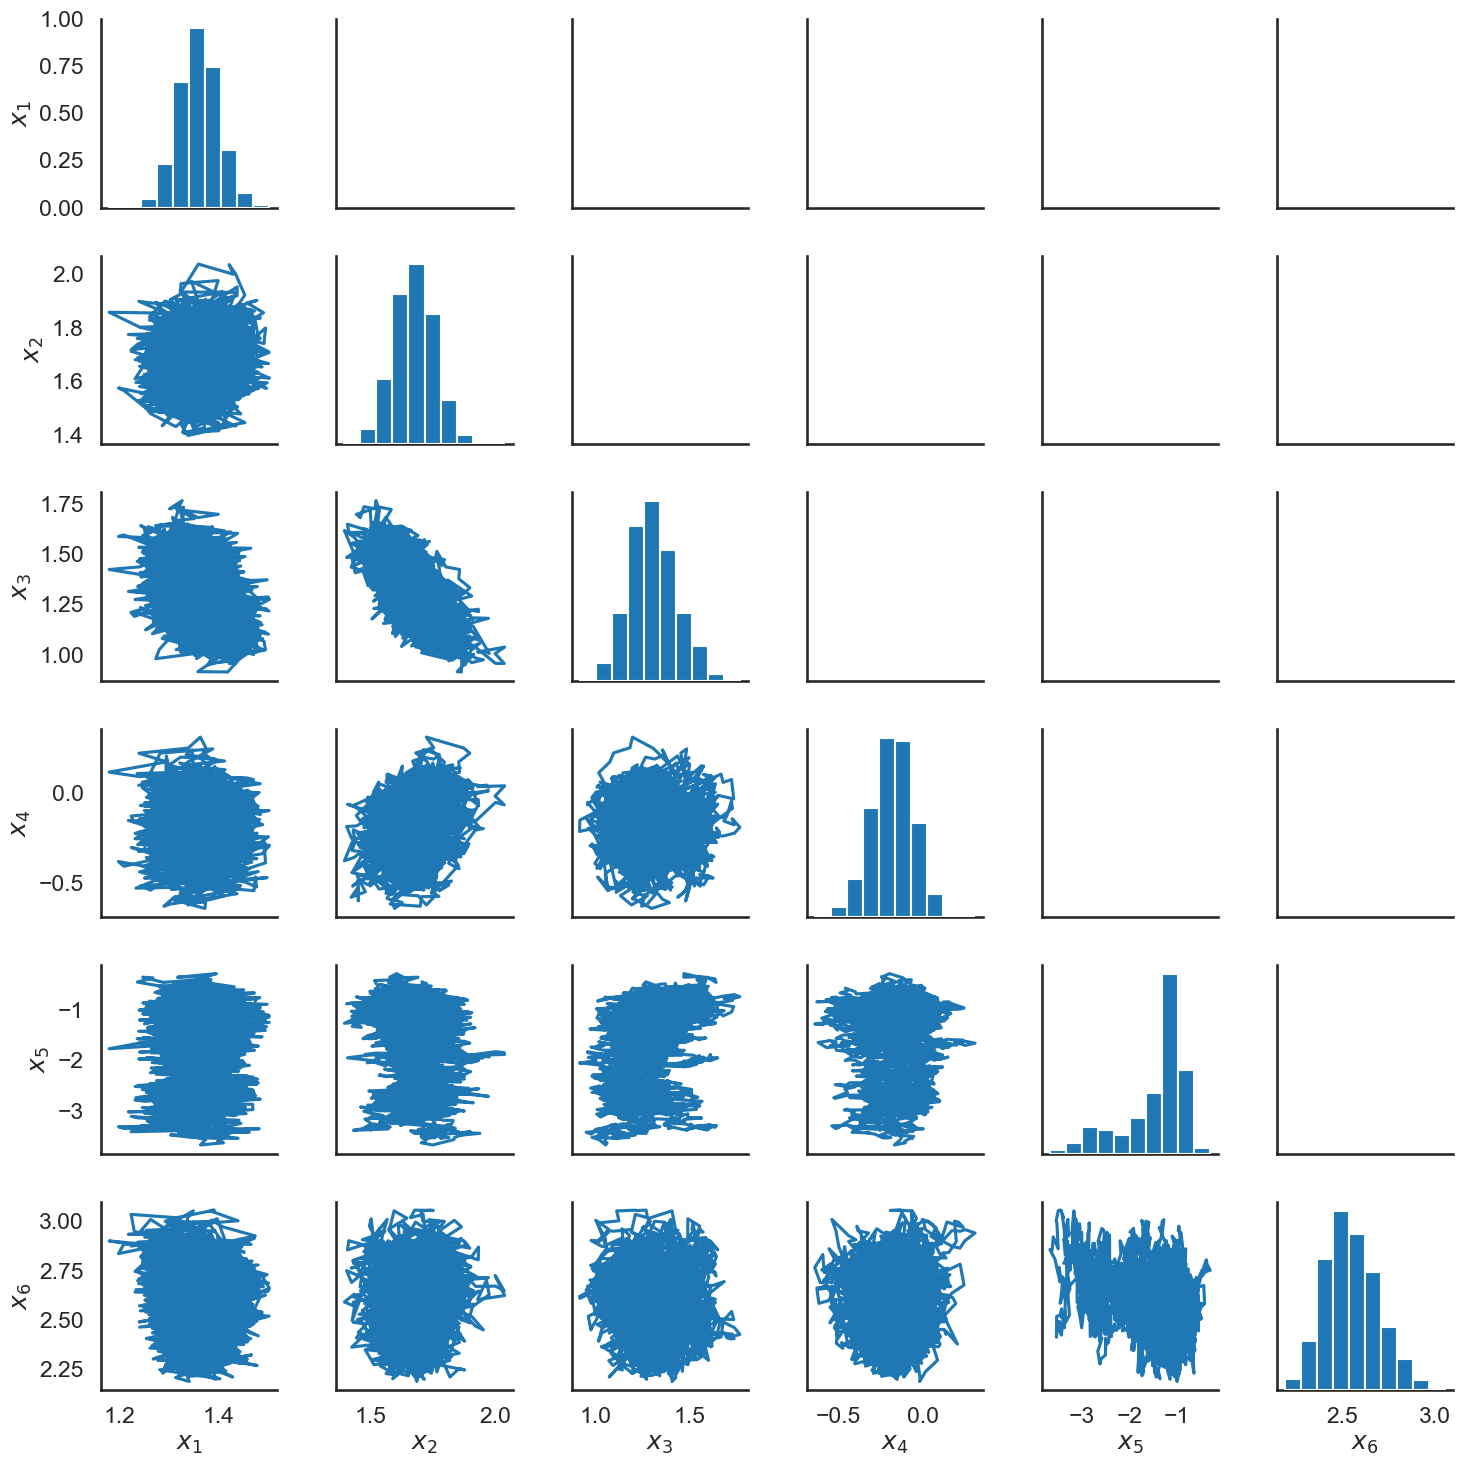

In [10]:
# Draw all pairwise scatter plots
# for i in range(Z.shape[1]):
#     for j in range(i + 1, Z.shape[1]):
#         fig, ax = plt.subplots()
#         ax.plot(Z[:, i], Z[:, j], lw=1)
#         ax.set_xlabel('$x_{%d}$' % (i + 1))
#         ax.set_ylabel('$x_{%d}$' % (j + 1));
df = pd.DataFrame(Z, columns=['$x_{%d}$' % (i + 1) for i in range(Z.shape[1])])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(plt.plot)
gg.map_diag(plt.hist);

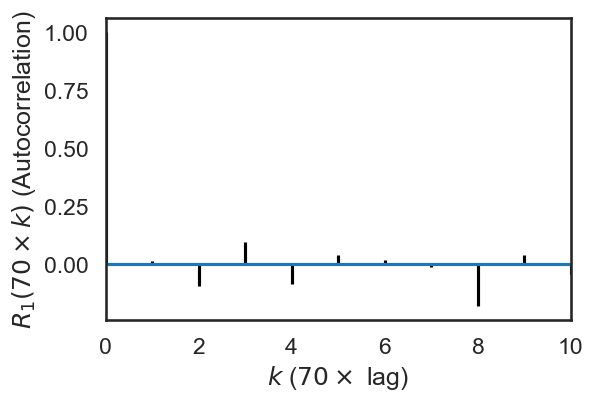

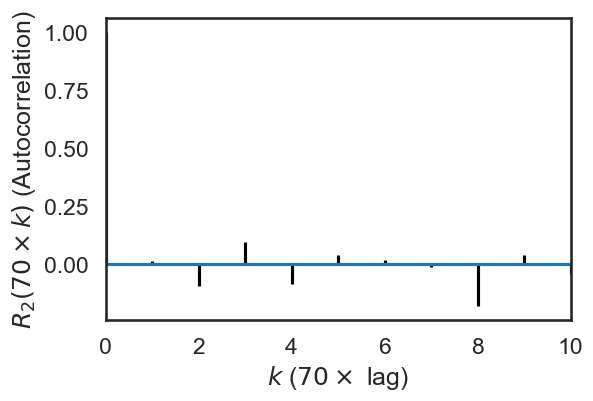

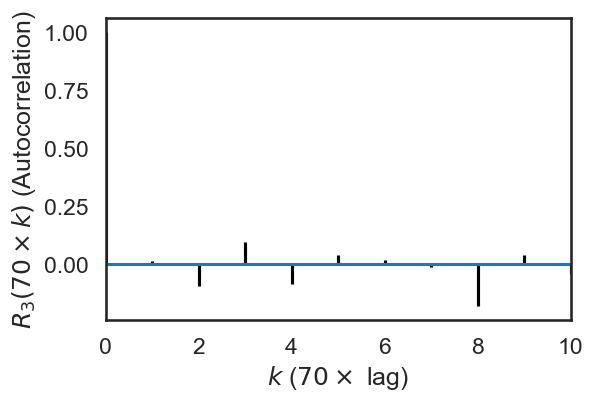

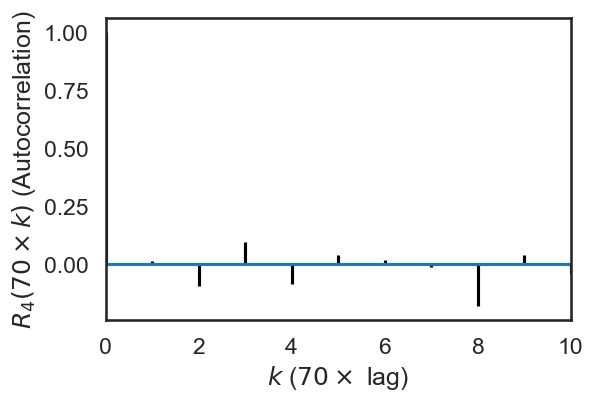

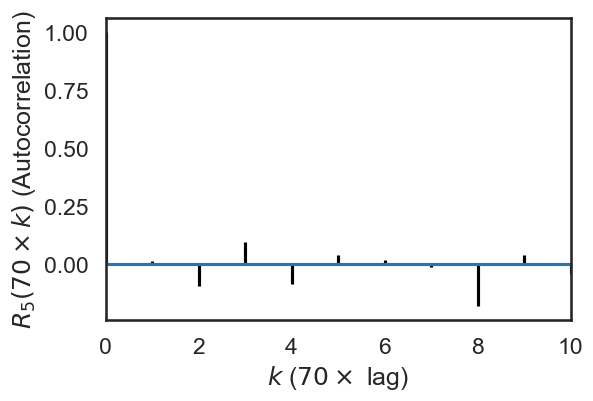

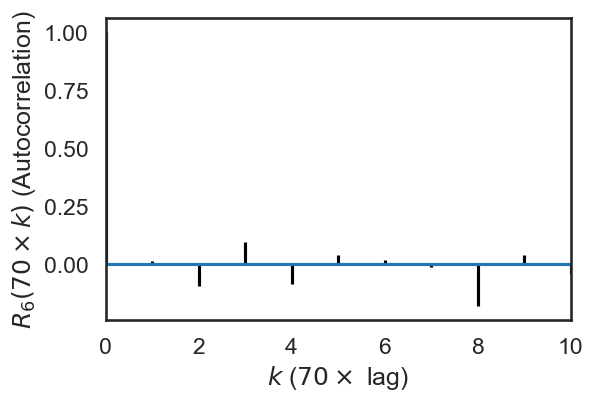

In [11]:
# How many samples do you want to burn?
burn = 1
# How many samples do you want to throw in between?
thin = 70 # Keep one every ten samples (k*)
# Here are the remaining samples:
Z_rest = Z[burn::thin]
for i in range(Z_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(Z_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=10)
    ax.set_xlim(0, 10)
    ax.set_ylabel(r'$R_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

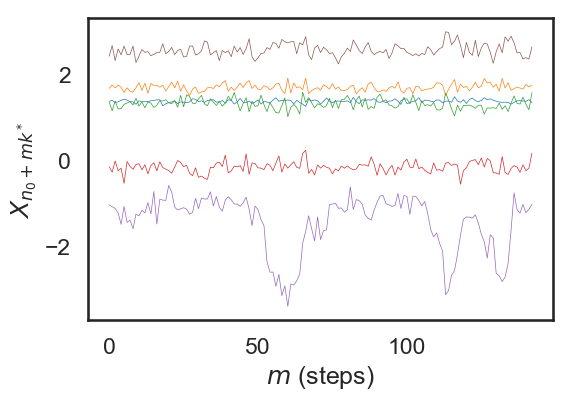

In [12]:
fig, ax = plt.subplots()
ax.plot(Z_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$');

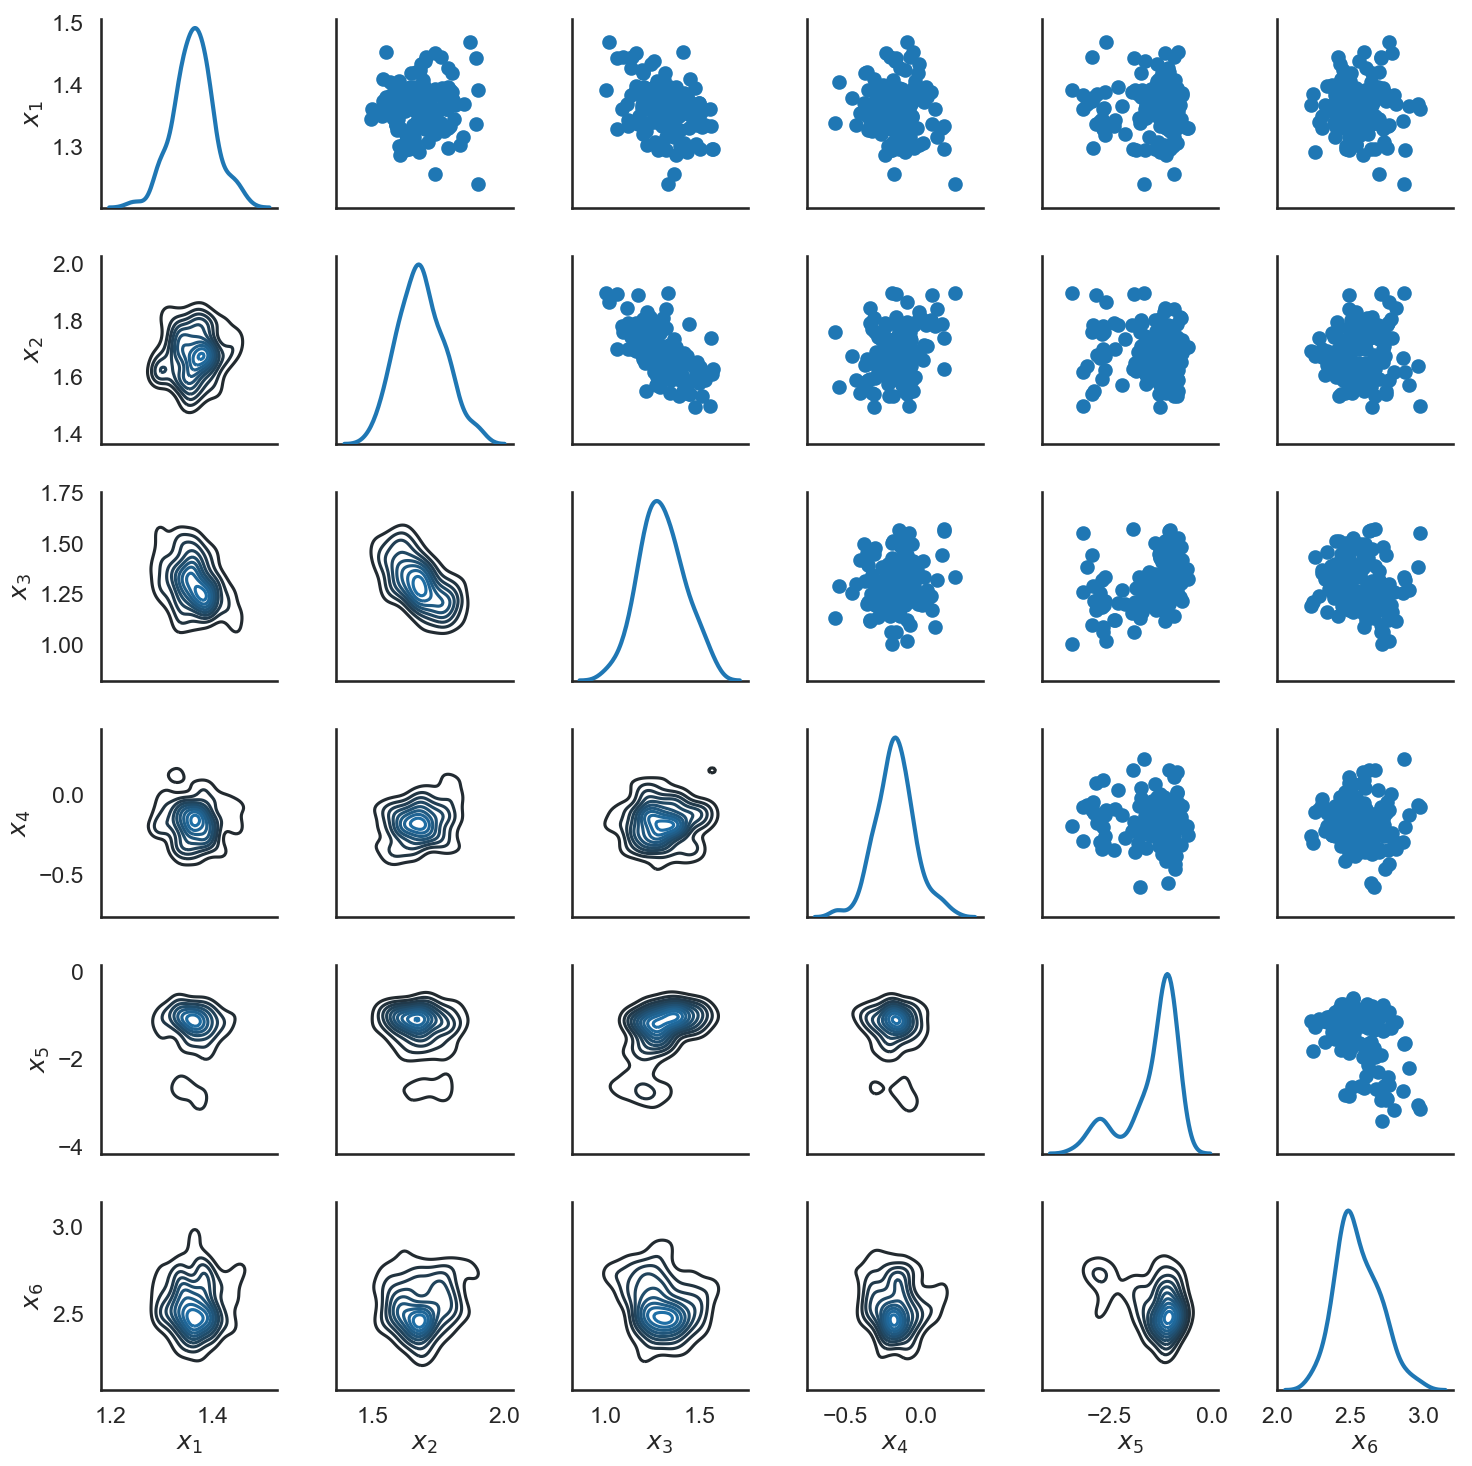

In [13]:
# Now let's do all the pairwise scatter plots for the x-s.
df = pd.DataFrame(Z_rest, columns=['$x_{%d}$' % (i + 1) for i in range(Z_rest.shape[1])])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

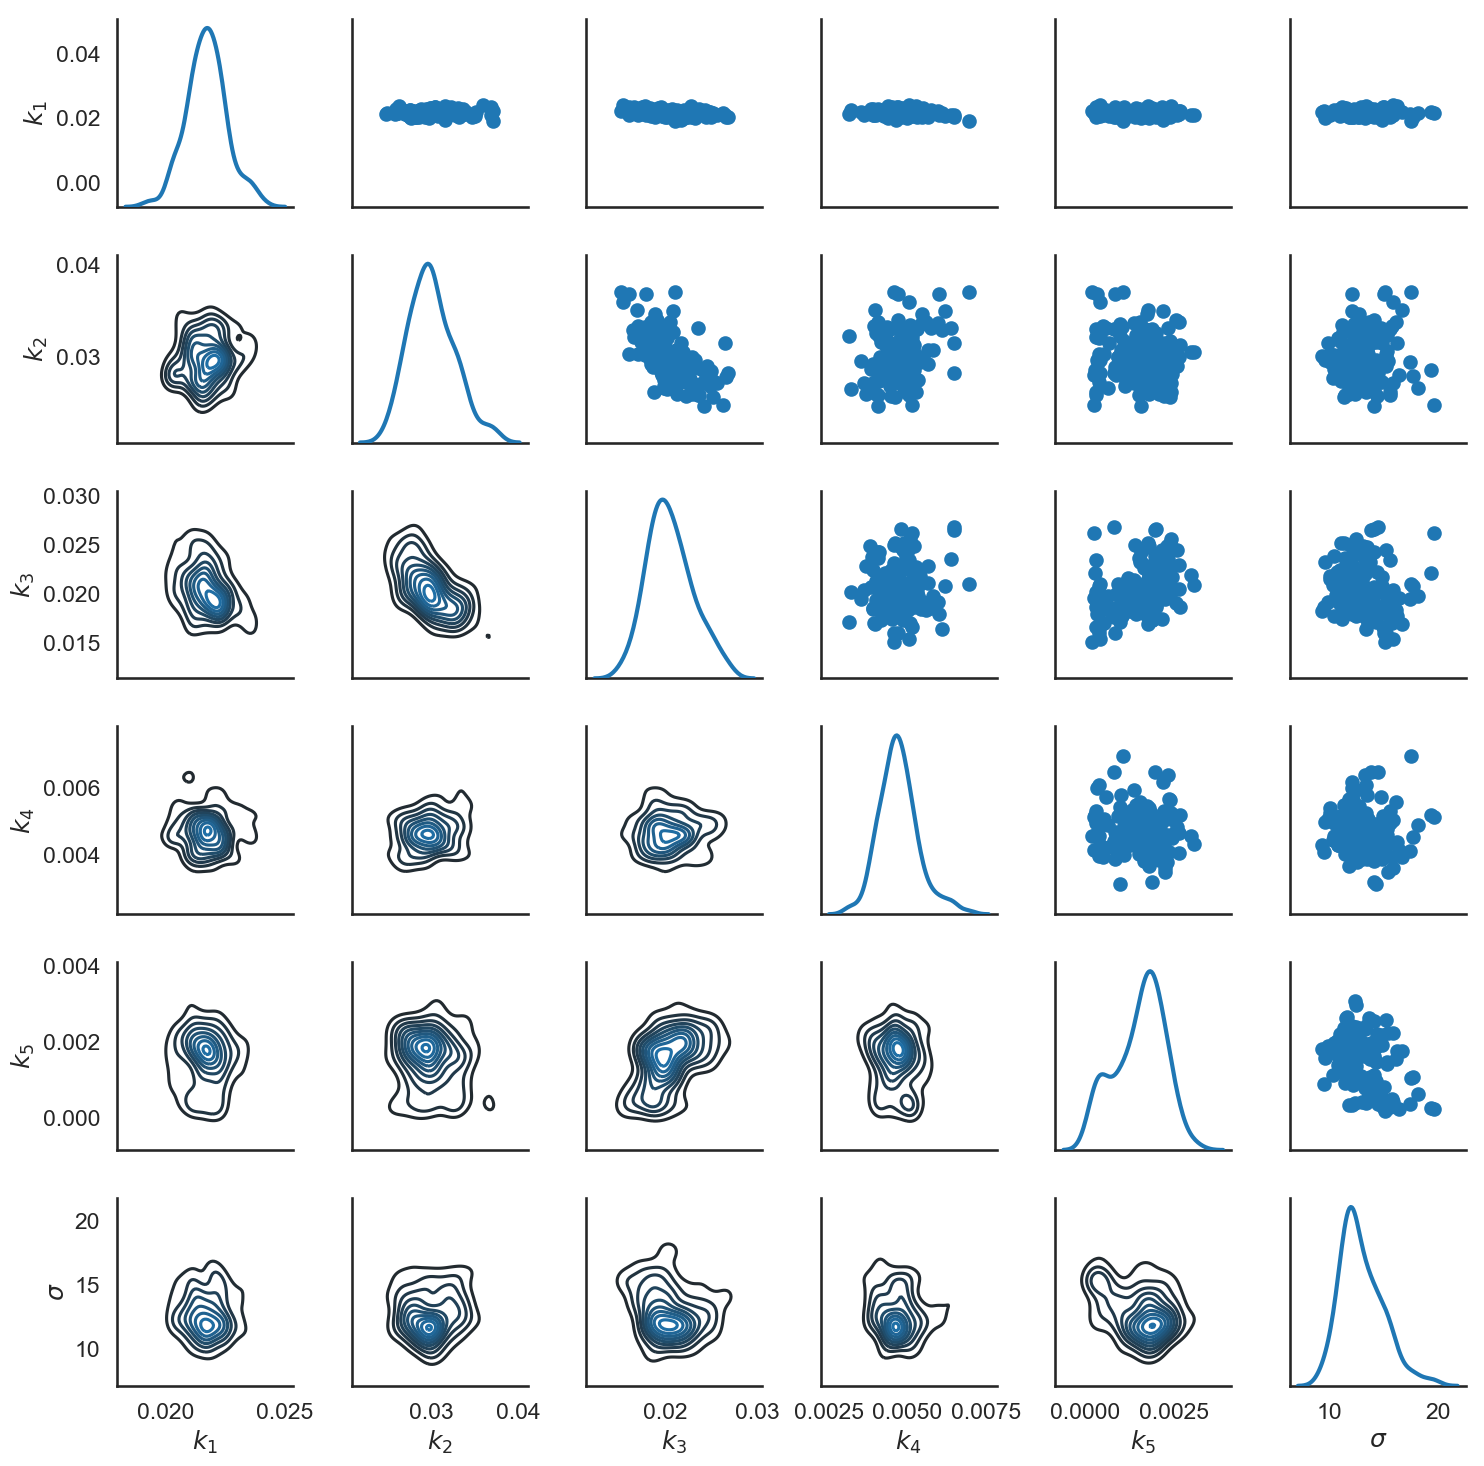

In [14]:
# Now let's transform back to our k's and repeat the procedure
K_rest = np.exp(Z_rest[:, :-1]) / 180.
sigmas = np.exp(Z_rest[:, -1])
Z_rest_trans = np.hstack([K_rest, sigmas[:, None]])
df = pd.DataFrame(Z_rest_trans, columns=['$k_{%d}$' % (i + 1) for i in range(K_rest.shape[1])] + ['$\sigma$'])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

### Questions

+ Are the steps we took sufficient? Increase ``n`` (the number of steps) and observe how the results change. You will have to wait. Go for a walk while this runs.
    - With more steps $n$, the final distributions of the parameters looks more concentrated and well defined as there are more data points from distribution

## Combining Transition Kernels

Now, let's get back to the original problem of sampling from:
$$
\pi(x) = \frac{h(x)}{Z}.
$$
Assume that you have $m$ different Markov kernels, $K_1(x,x'), \dots, K_m(x,x')$ (which could be Metropolis-Hastings kernels) that leave $\pi(x)$ invariant.
Then, the Markov kernel that consists of applying these kernels in order also leaves $\pi(x)$ invariant.
This kernel is:
$$
K(x,x') = \int K_1(x, x_1)K_2(x_1, x_2)\dots K_m(x_{m-1}, x')dx_1dx_2\dots dx_{m-1}.
$$
The proof is trivial:
$$
\begin{array}{ccc}
\int \pi(x) K(x, x') dx &=& \int \pi(x) \int K_1(x, x_1)K_2(x_1, x_2)\dots K_m(x_{m-1}, x')dx_1dx_2\dots dx_{m-1} dx\\
&=& \int \left(\int \pi(x) K(x, x_1) dx \right) K_2(x_1, x_2)\dots K_m(x_{m-1}, x')dx_1dx_2\dots dx_{m-1} \\
&=& \int \pi(x_1) K_3(x_2, x_4)\dots K_m(x_{m-1}, x')dx_2dx_3\dots dx_{m-1}\\
&=& \int \left(\pi(x_1) K_2(x_1, x_2)dx_1\right)K_3(x_2, x_4)\dots K_m(x_{m-1}, x')dx_2dx_3\dots dx_{m-1}\\
&=& \int \pi(x_2)K_3(x_2, x_4)\dots K_m(x_{m-1}, x')dx_2dx_3\dots dx_{m-1}\\
&=& \dots\\
&=& \pi(x').
\end{array}
$$

So, if you have many Metropolis-Hastings kernels, or any other kernels really, you can combine them all together in arbitrary ways.
You will still be getting samples from the target distribution.

## Gibbs Sampler

The Gibbs sampler is based on the idea of combining kernels that operate on groups of components of your random variables and exploit the availability of the conditional distributions.
For example, assume that $x$ consists of $m$ groups:
$$
x = (x_{g1}, \dots, x_{gm}).
$$
Note that each group may consist of more than one variables.
That is, the number of groups $m\le d$.

Let $x_{gi}$ denote the $i$-th group of variables, $i=1,\dots,m$, and
$$
x_{g,-i} = \left(x_{g1},\dots,x_{g,i-1},x_{g,i+1},\dots,x_{gm}\right),
$$
all groups except $i$.
Of course, we have that:
$$
x = (x_{gi}, x_{g,-i}).
$$
To implement a Gibbs sampler, we need the ability to sample from the conditional probability densities:
$$
\pi(x_{gi} | x_{g,-i}) = \frac{\pi(x_{gi},x_{g,-i})}{\pi(x_{g-i})}.
$$
If it is possible to sample easily from this distribution, then we are all set.
Then we say that we are using an *exact Gibbs sampler*.
If analytical samples are not possible, then we can simply construct a Metropolis-Hastings kernel that samples from the conditional (you just think of $x_{g,-i}$ as given when you are using this kernel.
Then we say that we are using an *approximate Gibbs sampler*.

There are many possible versions of the Gibbs depending on how we select from which conditional to sample next.
The simplest version is this following in which we sample from all the conditionals in order:

+ Initialize the sampler:
$$
x_0 = (x_{0g1},\dots,x_{0gm}).
$$

+ For steps $t=1,2\dots$ do:
    - Set:
        $$
            x_{t} \leftarrow x_{t-1}.
        $$
    - Sample from the conditional of group $i$:
        $$
        x_{tgi} \sim \pi(\cdot|x_{tg,-i}).
        $$
        
There are various flavors of the (approximate) Gibbs sampler; each one with its own pros and cons.
For example, another very common approach is to select $i$ at random for each step $t$.

## Example 3: The Catalysis Problem Revisited

Let's see how we can use approximate Gibbs sampling to estimate both $\sigma^2$ and $\gamma^2$ along side $x$.
The prior for $\sigma^2$ (after following the standard tranformation formula) is:
$$
p(\sigma^2) \propto \sigma^{-2}.
$$
We assign the same unininformative prior to $\gamma^2$:
$$
p(\gamma^2) \propto \gamma^{-2}.
$$

The posterior of all our parameters are:
$$
\begin{gather*}
p(x,\sigma^2,\gamma^2|y) &\propto& p(y|x,\sigma^2)p(x|\gamma^2)p(\sigma^2)p(\gamma^2) \\
&=& \left(2\pi\sigma^2\right)^{-\frac{m}{2}}\exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma^2}\right\}\left(2\pi\gamma^2\right)^{-\frac{d}{2}}\exp\left\{-\frac{\parallel x\parallel_2^2}{2\gamma^2}\right\}\sigma^{-2}\gamma^{-2}.
\end{gather*}
$$
Let's work out the conditionals.
We have:
$$
p(x|\sigma^2,\gamma^2, y) = \frac{p(x,\sigma^2,\gamma^2|y)}{p(\sigma^2,\gamma^2|y)} \propto \exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma^2}-\frac{\parallel x\parallel_2^2}{2\gamma^2}\right\},
$$
for which, unfortunately, we can only use a standard Metropolis sampler.
For $\sigma^2$ we have:
$$
p(\sigma^2 | x, \gamma^2, y) = \frac{p(x,\sigma^2,\gamma^2|y)}{p(x,\gamma^2|y)} \propto \left(\sigma^2\right)^{-\frac{m}{2}-1}\exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma^2}\right\},
$$
in which we recognize the PDF of the [inverse-gamma](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) distribution:
$$
p(\sigma^2 | x, \gamma^2, y) = \mbox{Inv-Gamma}\left(\sigma^2\middle|\alpha=\frac{m}{2}, \beta=\frac{\parallel y-f(x)\parallel_2^2}{2}\right).
$$
From this density, it is possible to sample without the need of a Metrpolis step.
Similarly, for $\gamma^2$ we have:
$$
\begin{gather*}
p(\gamma^2|x,\sigma^2,y) &=& \frac{p(x,\sigma^2,\gamma^2|y)}{p(x,\sigma^2|y)}\\
&\propto& \left(\gamma^2\right)^{-\frac{d}{2}-1}\exp\left\{-\frac{\parallel x\parallel_2^2}{2\gamma^2}\right\}\\
&=&\mbox{Inv-Gamma}\left(\gamma^2\middle|\alpha=\frac{d}{2}, \beta=\frac{\parallel x\parallel_2^2}{2}\right),
\end{gather*}
$$

So, an (approximate) Gibbs sampler for our catalysis problem would work as follows:

+ Pick initial $x_0$ and $\sigma_0^2$.

+ For $t=1,2,\dots$:
    
    + Sample $x_t$ from:
        $$
        p(x_t|\sigma_{t-1}^2, \gamma_{t-1}^2, y) \propto \exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma_{t-1}^2}-\frac{\parallel x\parallel_2^2}{2\gamma_{t-1}^2}\right\},
        $$
      by doing one (or more) step(s) of a random walk metropolis with $x_{t-1}$ as the starting point.
      
    + Directly sample $\sigma_t^2$ from:
        $$
        p(\sigma_t^2|x_t, \gamma_{t-1}^2, y) = \mbox{Inv-Gamma}\left(\sigma^2_t\middle|\alpha=\frac{m}{2}, \beta=\frac{\parallel y-f(x_t)\parallel_2^2}{2}\right).
        $$
        
    + Directly sample $\gamma_t^2$ from:
        $$
        p(\gamma_t^2|x_t, \sigma_t^2, y) = \mbox{Inv-Gamma}\left(\gamma^2\middle|\alpha=\frac{d}{2}, \beta=\frac{\parallel x_t\parallel_2^2}{2}\right).
        $$

In [15]:
# This is what we need for the random walk metropolis
def log_cond_x(x, sigma2, gamma2, y):
    m = y.shape[0]
    k = np.exp(x) / 180.
    t_exp = np.linspace(0, 180, 7)
    res = cat_solver(x, t_exp)[1:, :]
    Z = np.hstack([res[:, :2], res[:, 3:]])
    f = Z.flatten()
    tmp = (y - f)
    log_h = - 0.5 * np.sum(tmp ** 2) / sigma2 - 0.5 * np.sum(x ** 2) / gamma2
    return log_h, f

In [16]:
# Approximate Gibbs Sampler
# Dimensions
m = y.shape[0]
d = 5
# Initialize
sigma20 = 100.
gamma20 = 1.
x0 = np.sqrt(gamma20) * np.random.randn(d)
# Total number of steps
n = 10000
# Random walk proposal step:
sigma_prop = 0.1
# Number of rwmetropolis steps per Gibbs step
num_rw_steps = 10
# Storage for the parameters
sigma2s = [sigma20]
gamma2s = [gamma20]
xs = [x0]
# Start the algorithm
ars_sum = 0.
for t in range(n):
    # Sample a few steps from p(x | sigma2, gamma2, y) using a random walk metropolis
    tmp, ar, other = rwmetropolis(xs[-1], log_cond_x, num_rw_steps, sigma_prop, args=(sigma2s[-1], gamma2s[-1], y))
    ars_sum += ar
    x_new = tmp[-1, :]
    f = other[-1]
    diff = y - f
    # Sample new sigma2:
    sigma2_new = st.invgamma(a=0.5 * m, scale=0.5 * np.sum(diff ** 2)).rvs()
    # Sample new gamma2
    gamma2_new = st.invgamma(a=0.5 * d, scale=0.5 * np.sum(x_new ** 2)).rvs()
    # Store samples
    xs.append(x_new)
    sigma2s.append(sigma2_new)
    gamma2s.append(gamma2_new)
print('Total acceptance rate of Metropolis part: %1.3f' % (ars_sum / n))

Total acceptance rate of Metropolis part: 0.153


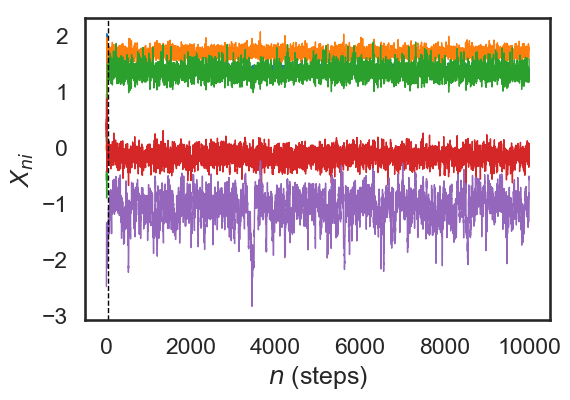

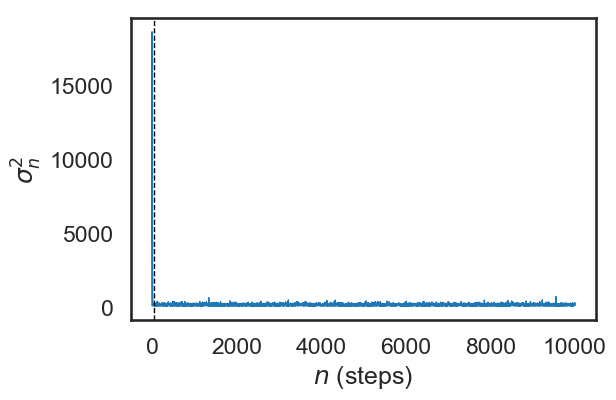

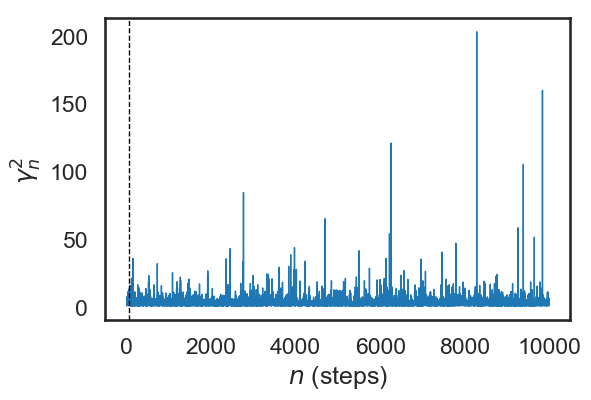

In [17]:
burn = 50
fig, ax = plt.subplots()
ax.plot(range(n + 1), xs, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');
ax.axvline(x=burn, linestyle = '--', color ='black', linewidth = 1)
fig, ax = plt.subplots()
ax.plot(range(n + 1), sigma2s, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\sigma^2_n$');
ax.axvline(x=burn, linestyle = '--', color ='black', linewidth = 1)
fig, ax = plt.subplots()
ax.plot(range(n + 1), gamma2s, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2_n$')
ax.axvline(x=burn, linestyle = '--', color ='black', linewidth = 1);

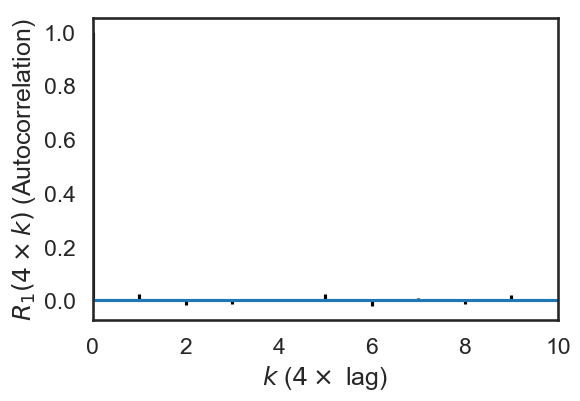

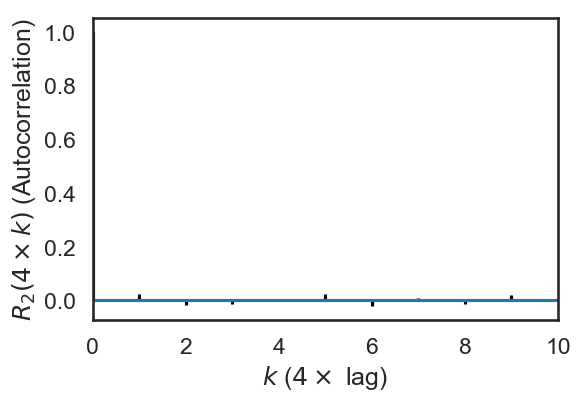

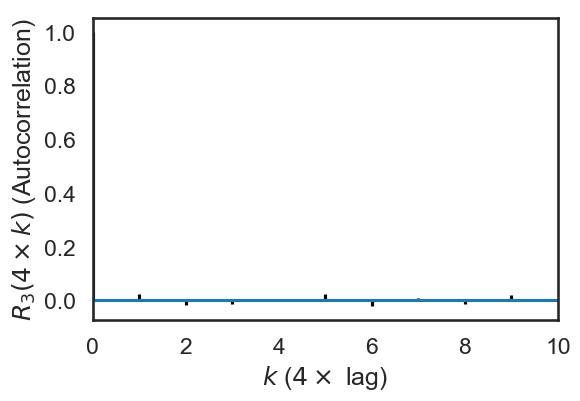

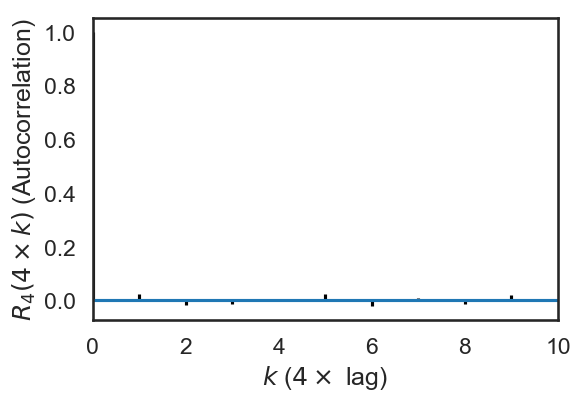

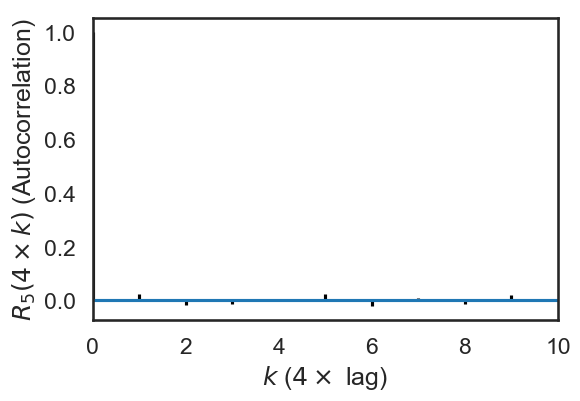

In [18]:
# How many samples do you want to burn?
burn = 50
# How many samples do you want to throw in between?
thin = 4 # Keep one every ten samples (k*)
# Here are the remaining samples:
xs_rest = np.array(xs[burn::thin])
for i in range(d):
    fig, ax = plt.subplots()
    ax.acorr(xs_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=10)
    ax.set_xlim(0, 10)
    ax.set_ylabel(r'$R_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

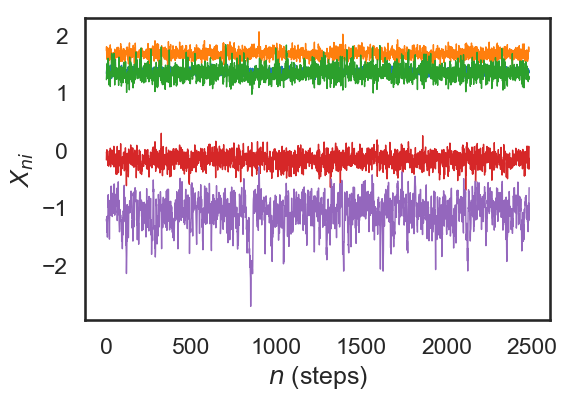

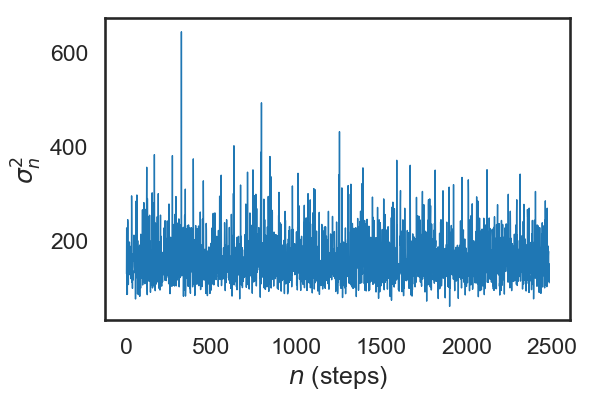

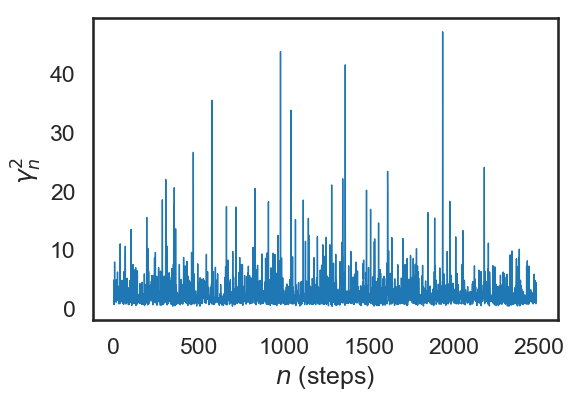

In [19]:
fig, ax = plt.subplots()
ax.plot(xs_rest, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');
sigma2s_rest = sigma2s[burn::thin]
fig, ax = plt.subplots()
ax.plot(sigma2s_rest, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\sigma^2_n$');
gamma2s_rest = gamma2s[burn::thin]
fig, ax = plt.subplots()
ax.plot(gamma2s_rest, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2_n$');

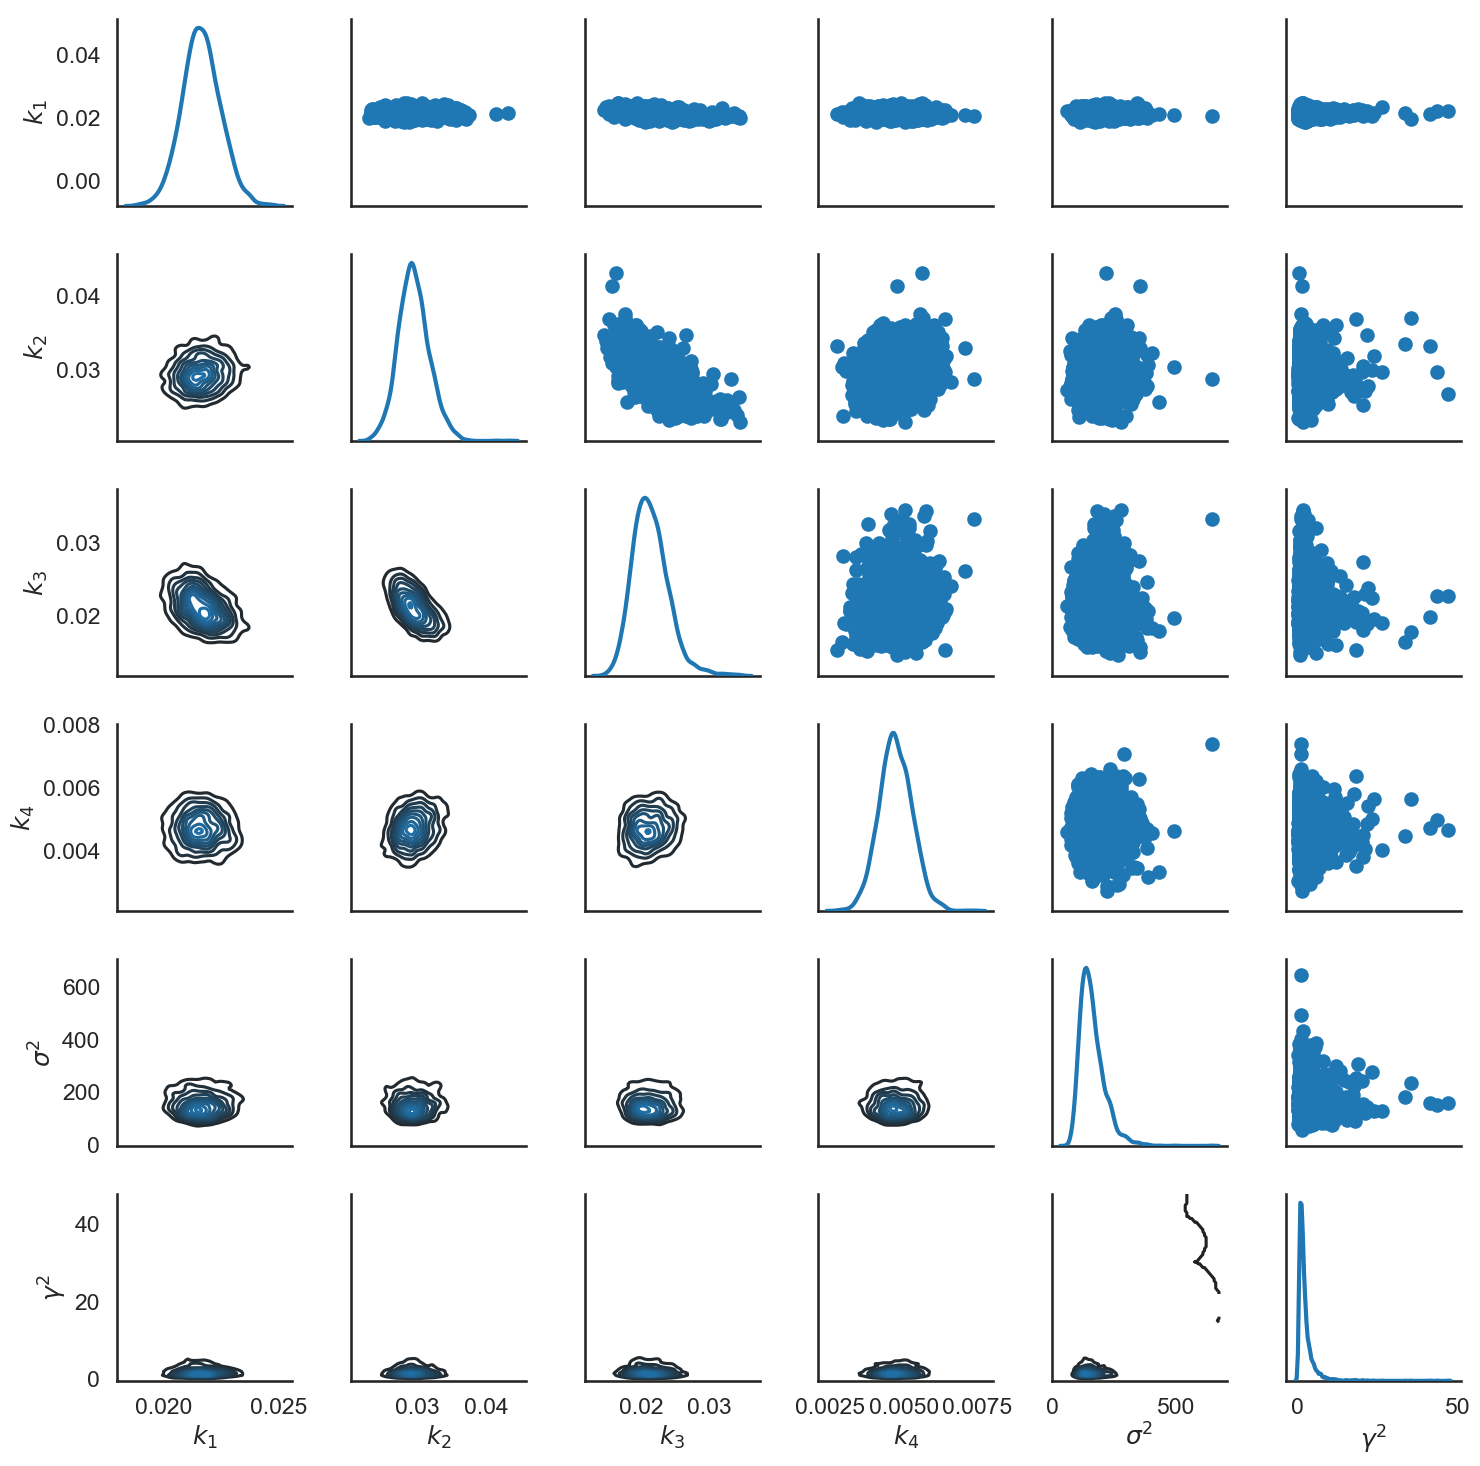

In [20]:
# Now let's plot the posterior pdf's of our k's 
K_rest = np.exp(xs_rest[:, :-1]) / 180.
Z_rest_trans = np.hstack([K_rest, np.array(sigma2s_rest)[:, None], np.array(gamma2s_rest)[:, None]])
df = pd.DataFrame(Z_rest_trans, columns=['$k_{%d}$' % (i + 1) for i in range(K_rest.shape[1])] + ['$\sigma^2$', '$\gamma^2$'])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

### Questions

+ You probably need to run the Gibbs sampler for 10 times as many steps as we did. MCMC seems to still be in the transient regime. Go ahead and do this by modifying ``n`` (the total number of steps) to 10000. However, be prepared to wait. This may be the time to go for that walk...